## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from time import time
import os
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import itertools
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train = True, 
                                                        transform = train_transform,
                                                        target_transform = None,
                                                        download = download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train = False, 
                                                       transform = test_transform,
                                                       target_transform = None,
                                                       download = download)
def test_train_split(dataset, split = 0.8):    
    """
    Looks similar to sklearn one.
    Params:
    --------------
    dataset -- torch.utils.data.Dataset to split
    split -- float, split (to train size)
    Returns:
    --------------
    train_set, valid_set -- splitted Datasets of size:
    (split * len(dataset), len(dataset) - len(train_set))
    """
    train_size = int(split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

train_set, valid_set = test_train_split(fmnist_dataset_train, .75)



In [4]:
len(fmnist_dataset_test)
train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)


In [5]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [6]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
#             nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes))
        
    def forward(self, x):       
        return self.model(x)
    

In [7]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Dropout-3                  [-1, 128]               0
       BatchNorm1d-4                  [-1, 128]             256
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 118,794
Trainable params: 118,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.47
-------------------------------------------

Your experiments come here:

Epoch 1 of 18 took 13.965s
	  training loss: 0.554728
	validation loss: 0.416153
	validation accuracy: 0.849
Epoch 2 of 18 took 12.672s
	  training loss: 0.391419
	validation loss: 0.370761
	validation accuracy: 0.863
Epoch 3 of 18 took 11.667s
	  training loss: 0.354504
	validation loss: 0.346662
	validation accuracy: 0.874
Epoch 4 of 18 took 11.679s
	  training loss: 0.330800
	validation loss: 0.350428
	validation accuracy: 0.871
Epoch 5 of 18 took 11.229s
	  training loss: 0.316201
	validation loss: 0.324261
	validation accuracy: 0.884
Epoch 6 of 18 took 11.802s
	  training loss: 0.302818
	validation loss: 0.343247
	validation accuracy: 0.876
Epoch 7 of 18 took 12.387s
	  training loss: 0.291440
	validation loss: 0.323406
	validation accuracy: 0.884
Epoch 8 of 18 took 11.600s
	  training loss: 0.281513
	validation loss: 0.348484
	validation accuracy: 0.872
Epoch 9 of 18 took 11.332s
	  training loss: 0.267297
	validation loss: 0.335652
	validation accuracy: 0.878
Epoch 10 of 18 took

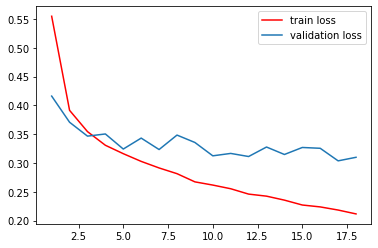

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

def train_model(model, train_set, valid_set, loss_fn, opt, n_epochs: int, device = device):
    
    train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)
    valid_loader = DataLoader(valid_set, batch_size = 256,
                                           shuffle = False,
                                           num_workers = 2)
    
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1] 
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

def evaluate_model(model, test_set, loss_fn, opt):
    test_loader = DataLoader(test_set, batch_size = 256,
                                          shuffle = False,
                                          num_workers = 2)
    _ = model.eval()
    print("\n\n TESTING MODEL...")
    losses = []
    metrics = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            y_pred = predictions.max(1)[1]
            losses.append(loss.item())
            metrics.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))
            
    print(f"\t test loss: {np.mean(losses):.6f}")
    print(f"\t test accuracy: {np.mean(metrics):.3f}")

    
    return np.mean(losses), np.mean(metrics)
# Your experiments, training and validation loops here
n_epochs = 18
train_loss, val_loss, val_accuracy = train_model(model, train_set, valid_set,
                                                loss_func, opt, n_epochs)
_ = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
plt.plot(np.arange(1, n_epochs + 1, 1), train_loss, color = 'r', label = 'train loss')
plt.plot(np.arange(1, n_epochs + 1, 1), val_loss, label = 'validation loss')
plt.legend(loc = 'best')


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [10]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, n_layers = 1,
                 input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        hidden_dim = 128
        self.model = torch.nn.Sequential(nn.Flatten())
        prev_layer_input_dim = input_shape
        for layer in range(n_layers):
            self.model.add_module('Layer {}'.format(layer + 1), 
                                  torch.nn.Linear(in_features = prev_layer_input_dim, 
                                                 out_features = hidden_dim))
            self.model.add_module("BatchNorm {}".format(layer + 1), 
                                  torch.nn.BatchNorm1d(hidden_dim))
            prev_layer_input_dim = hidden_dim
            
        self.model.add_module('classifier', 
                               torch.nn.Linear(prev_layer_input_dim, num_classes)) 
        
    def forward(self, x):       
        return self.model(x)

In [11]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                   [-1, 10]           1,290
Total params: 102,026
Trainable params: 102,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [13]:
train_set, _ = test_train_split(fmnist_dataset_train, .25)
loss_func = nn.CrossEntropyLoss()

def get_overfitting(layers_range):  
    test = {"loss": [], "acc": []}
    train = {"loss": [], "acc": []}
    for n_layers in range(layers_range - 1, 1, -1):
        print("n_layers = ", n_layers)
        model = OverfittingNeuralNetwork(n_layers = n_layers).to(device)
        opt = torch.optim.Adam(model.parameters())
        train_loss, val_loss, val_accuracy = train_model(model, train_set, 
                                                    valid_set,
                                                    loss_func, opt, 20)
        test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
        train['loss'].append(np.mean(val_loss)); train['acc'].append(np.mean(val_accuracy))
        test['loss'].append(test_loss); test['acc'].append(test_accuracy)
    return train, test
train_data, test_data = get_overfitting(layers_range = 12)
# Your experiments, come here

n_layers =  11
Epoch 1 of 20 took 9.808s
	  training loss: 0.645760
	validation loss: 0.645713
	validation accuracy: 0.780
Epoch 2 of 20 took 10.345s
	  training loss: 0.512388
	validation loss: 0.574673
	validation accuracy: 0.816
Epoch 3 of 20 took 8.331s
	  training loss: 0.494512
	validation loss: 0.675275
	validation accuracy: 0.758
Epoch 4 of 20 took 8.129s
	  training loss: 0.472695
	validation loss: 0.521023
	validation accuracy: 0.816
Epoch 5 of 20 took 8.181s
	  training loss: 0.452602
	validation loss: 0.542164
	validation accuracy: 0.812
Epoch 6 of 20 took 8.909s
	  training loss: 0.443381
	validation loss: 0.480318
	validation accuracy: 0.836
Epoch 7 of 20 took 8.586s
	  training loss: 0.432004
	validation loss: 0.489466
	validation accuracy: 0.833
Epoch 8 of 20 took 8.243s
	  training loss: 0.418088
	validation loss: 0.487941
	validation accuracy: 0.829
Epoch 9 of 20 took 8.909s
	  training loss: 0.428691
	validation loss: 0.555706
	validation accuracy: 0.819
Epoch 10 of 

Epoch 15 of 20 took 7.867s
	  training loss: 0.376967
	validation loss: 0.492559
	validation accuracy: 0.830
Epoch 16 of 20 took 8.057s
	  training loss: 0.367926
	validation loss: 0.532514
	validation accuracy: 0.818
Epoch 17 of 20 took 7.235s
	  training loss: 0.375583
	validation loss: 0.590510
	validation accuracy: 0.818
Epoch 18 of 20 took 7.591s
	  training loss: 0.375116
	validation loss: 0.498722
	validation accuracy: 0.832
Epoch 19 of 20 took 7.807s
	  training loss: 0.362609
	validation loss: 0.504532
	validation accuracy: 0.826
Epoch 20 of 20 took 7.244s
	  training loss: 0.366484
	validation loss: 0.510919
	validation accuracy: 0.834


 TESTING MODEL...
	 test loss: 0.586324
	 test accuracy: 0.814
n_layers =  7
Epoch 1 of 20 took 7.808s
	  training loss: 0.641253
	validation loss: 0.524298
	validation accuracy: 0.817
Epoch 2 of 20 took 7.049s
	  training loss: 0.492216
	validation loss: 0.542144
	validation accuracy: 0.816
Epoch 3 of 20 took 7.617s
	  training loss: 0.47358

Epoch 8 of 20 took 6.127s
	  training loss: 0.386844
	validation loss: 0.552823
	validation accuracy: 0.805
Epoch 9 of 20 took 5.693s
	  training loss: 0.385792
	validation loss: 0.506056
	validation accuracy: 0.830
Epoch 10 of 20 took 5.935s
	  training loss: 0.380008
	validation loss: 0.496892
	validation accuracy: 0.825
Epoch 11 of 20 took 6.144s
	  training loss: 0.379455
	validation loss: 0.455047
	validation accuracy: 0.845
Epoch 12 of 20 took 6.761s
	  training loss: 0.365678
	validation loss: 0.492096
	validation accuracy: 0.836
Epoch 13 of 20 took 5.872s
	  training loss: 0.363070
	validation loss: 0.487394
	validation accuracy: 0.837
Epoch 14 of 20 took 6.626s
	  training loss: 0.361951
	validation loss: 0.541510
	validation accuracy: 0.821
Epoch 15 of 20 took 6.415s
	  training loss: 0.354332
	validation loss: 0.494993
	validation accuracy: 0.832
Epoch 16 of 20 took 5.587s
	  training loss: 0.348203
	validation loss: 0.466576
	validation accuracy: 0.844
Epoch 17 of 20 took 5

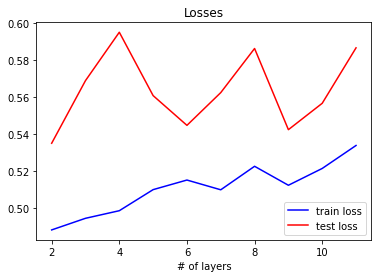

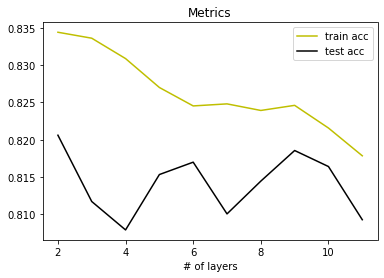

In [18]:
plt.title("Losses")
plt.plot(np.arange(11, 1, -1), train_data['loss'], color = 'b', label = "train loss")
plt.plot(np.arange(11, 1, -1), test_data['loss'], color = 'r', label = "test loss")
plt.xlabel("# of layers"); plt.legend(loc = "best")
plt.show()
plt.title("Metrics")
plt.plot(np.arange(11, 1, -1), train_data['acc'], color = 'y', label = "train acc")
plt.plot(np.arange(11, 1, -1), test_data['acc'], color = 'k', label = "test acc")
plt.xlabel("# of layers"); plt.legend(loc = "best")


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [48]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, n_layers = 1, input_shape = 28 * 28, num_classes = 10, 
                 input_channels = 1):
        super(self.__class__, self).__init__()
        hidden_dim = 128
        self.model = torch.nn.Sequential(nn.Flatten())
        prev_layer_input_dim = input_shape
        for layer in range(n_layers):
            self.model.add_module('Layer {}'.format(layer + 1), 
                                  torch.nn.Linear(in_features = prev_layer_input_dim, 
                                                 out_features = hidden_dim))
            self.model.add_module("Dropout {}".format(layer + 1), nn.Dropout(.5))
            self.model.add_module("BatchNorm {}".format(layer + 1), 
                                  torch.nn.BatchNorm1d(hidden_dim))
            prev_layer_input_dim = hidden_dim
            
        self.model.add_module('classifier', nn.Linear(prev_layer_input_dim, num_classes))
                       
        
    def forward(self, x):       
        out = self.model(x)
        return out
                            

In [49]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Dropout-3                  [-1, 128]               0
       BatchNorm1d-4                  [-1, 128]             256
            Linear-5                   [-1, 10]           1,290
Total params: 102,026
Trainable params: 102,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


n_layers =  0
Epoch 1 of 15 took 3.674s
	  training loss: 0.787899
	validation loss: 0.579712
	validation accuracy: 0.807
Epoch 2 of 15 took 5.006s
	  training loss: 0.538155
	validation loss: 0.513481
	validation accuracy: 0.828
Epoch 3 of 15 took 4.832s
	  training loss: 0.489294
	validation loss: 0.480025
	validation accuracy: 0.838
Epoch 4 of 15 took 4.452s
	  training loss: 0.464352
	validation loss: 0.457335
	validation accuracy: 0.848
Epoch 5 of 15 took 5.004s
	  training loss: 0.449338
	validation loss: 0.441151
	validation accuracy: 0.851
Epoch 6 of 15 took 4.811s
	  training loss: 0.437684
	validation loss: 0.433071
	validation accuracy: 0.854
Epoch 7 of 15 took 5.310s
	  training loss: 0.427498
	validation loss: 0.421657
	validation accuracy: 0.858
Epoch 8 of 15 took 5.426s
	  training loss: 0.419217
	validation loss: 0.416054
	validation accuracy: 0.862
Epoch 9 of 15 took 5.782s
	  training loss: 0.414480
	validation loss: 0.415061
	validation accuracy: 0.858
Epoch 10 of 15

Epoch 14 of 15 took 5.723s
	  training loss: 0.517461
	validation loss: 0.427376
	validation accuracy: 0.851
Epoch 15 of 15 took 5.871s
	  training loss: 0.513858
	validation loss: 0.420854
	validation accuracy: 0.857


 TESTING MODEL...
	 test loss: 0.468385
	 test accuracy: 0.835
n_layers =  5
Epoch 1 of 15 took 6.175s
	  training loss: 0.960453
	validation loss: 0.565059
	validation accuracy: 0.805
Epoch 2 of 15 took 5.949s
	  training loss: 0.694832
	validation loss: 0.509919
	validation accuracy: 0.825
Epoch 3 of 15 took 6.216s
	  training loss: 0.643915
	validation loss: 0.503556
	validation accuracy: 0.820
Epoch 4 of 15 took 15.063s
	  training loss: 0.621638
	validation loss: 0.470767
	validation accuracy: 0.840
Epoch 5 of 15 took 25.708s
	  training loss: 0.612687
	validation loss: 0.467300
	validation accuracy: 0.839
Epoch 6 of 15 took 24.776s
	  training loss: 0.597388
	validation loss: 0.462252
	validation accuracy: 0.838
Epoch 7 of 15 took 27.717s
	  training loss: 0.58549

Epoch 11 of 15 took 36.370s
	  training loss: 0.781797
	validation loss: 0.606792
	validation accuracy: 0.790
Epoch 12 of 15 took 30.559s
	  training loss: 0.780328
	validation loss: 0.611963
	validation accuracy: 0.784
Epoch 13 of 15 took 38.770s
	  training loss: 0.768470
	validation loss: 0.622081
	validation accuracy: 0.787
Epoch 14 of 15 took 38.867s
	  training loss: 0.766284
	validation loss: 0.604246
	validation accuracy: 0.789
Epoch 15 of 15 took 36.377s
	  training loss: 0.763712
	validation loss: 0.600847
	validation accuracy: 0.789


 TESTING MODEL...
	 test loss: 0.628018
	 test accuracy: 0.785
n_layers =  10
Epoch 1 of 15 took 40.415s
	  training loss: 1.459859
	validation loss: 0.951561
	validation accuracy: 0.634
Epoch 2 of 15 took 43.455s
	  training loss: 1.086788
	validation loss: 0.863417
	validation accuracy: 0.696
Epoch 3 of 15 took 41.618s
	  training loss: 1.030864
	validation loss: 0.805900
	validation accuracy: 0.722
Epoch 4 of 15 took 41.738s
	  training loss

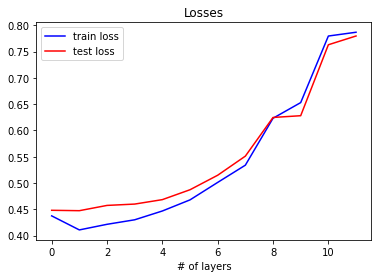

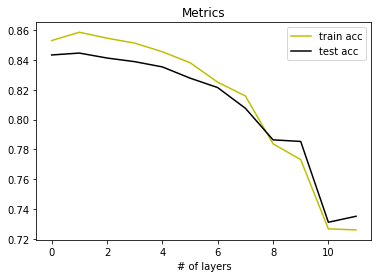

In [50]:
train_set, _ = test_train_split(fmnist_dataset_train, .75)
loss_func = nn.CrossEntropyLoss()
layers_range = 12

test_data = {"loss": [], "acc": []}
train_data = {"loss": [], "acc": []}
for n_layers in range(layers_range):
    print("n_layers = ", n_layers)
    model = FixedNeuralNetwork(n_layers = n_layers).to(device)
    opt = torch.optim.Adam(model.parameters())
    train_loss, val_loss, val_accuracy = train_model(model, train_set, 
                                                valid_set,
                                                loss_func, opt, 15)
    test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
    train_data['loss'].append(np.mean(val_loss))
    train_data['acc'].append(np.mean(val_accuracy))
    test_data['loss'].append(test_loss)
    test_data['acc'].append(test_accuracy)
plt.title("Losses")
plt.plot(np.arange(0, layers_range, 1), train_data['loss'], color = 'b', label = "train loss")
plt.plot(np.arange(0, layers_range, 1), test_data['loss'], color = 'r', label = "test loss")
plt.xlabel("# of layers"); plt.legend(loc = "best")
plt.show()
plt.title("Metrics")
plt.plot(np.arange(0, layers_range, 1), train_data['acc'], color = 'y', label = "train acc")
plt.plot(np.arange(0, layers_range, 1), test_data['acc'], color = 'k', label = "test acc")
plt.xlabel("# of layers"); plt.legend(loc = "best")

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._